In [1]:
#| default_exp datasets

In [2]:
#|export
from __future__ import annotations
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F

In [3]:
import torchvision.transforms.functional as TF
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

In [4]:
import logging
logging.disable(logging.WARNING)

## Hugging Face Datasets

After pip install datasets we can `from datasets import`, for now just 2:
`load_dataset, load_dataset_builder`. 

In [5]:
from datasets import load_dataset,load_dataset_builder

/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/germangoldszmidt/mambaforge/lib/python3

Lets look at a dataset called "Fashion_mnist". 
Like MNIST, it has 28x28 grayscale images, 10 categories, 60,000 training and 10,000 test examples. 
It's a direct drop-in replacement for MNIST.
We just give the name to `load_dataset_builder`, to get a `ds_builder` which has metadata about this dataset,
i.e., in `.info.description`: 

In [6]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.




The dataset builder will tell us what's in this dataset, via dictionaries rather  than tuples.

In [7]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

So there's `image` of type `Image`, and there's going to be a `label` of type `ClassLabel`,
there are 10 classes and these are the names of the classes. 

It also tells us if there are some recommended training test bits,  we can find out those as well. 
So this is the size  of the training split and the number of examples.

In [8]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, dataset_name='fashion_mnist')}

Now we can load the dataset using `load_dataset()` to download it and cache it.
And it creates a dataset  dictionary. 
A dataset dictionary is like what Fastai calls the datasets class. 
HF calls it the DatasetDict class, and it contains a `train` and a `test` datasets. 
These datasets are very much like the  datasets that we created in the previous notebook.  

In [9]:
dsd = load_dataset(name)
dsd

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

We can now grab the `train` and `test` items from that dictionary and pop them into variables, then
have a look at their first entries. As promised, it contains an image and a label.
We're not getting tuples anymore, we're getting dictionaries containing the x and y, in this case, `image` and `label`.  

In [10]:
train,test = dsd['train'],dsd['test']
train[0], test[0]

({'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  'label': 9},
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  'label': 9})

To avoid writing image and  label in strings, we store them as `x` and `y`.

In [11]:
x,y = ds_builder.info.features
x,y

('image', 'label')

We can now grab the first image `[0][x]`. 

In [12]:
img = train[0][x]
img

We could grab the first five images  and the first five labels, for example.  

In [13]:
xb = train[:5][x]
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

We know what the names of the classes are.

In [14]:
featy = train.features[y]
featy

ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

So we could now see what the `yb` map to by grabbing those features. 

In [15]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [16]:
train['label'][:5]

[9, 0, 0, 3, 0]

The collate function `collate_fn` returns a dictionary. (pretty common for Hugging Face stuff.)
It goes through the Dataset for each one and stacks them up, all in one step.
Then go through the batch `b`, grab the `y`s and stack them up with the integers so we don't have to call stack.(??)
Now we're now going to have the image and label in the dictionary.   

In [17]:
def collate_fn(b):
    return {x:torch.stack([TF.to_tensor(o[x]) for o in b]),
            y:tensor([o[y] for o in b])}

`collate_fn` got the batch `b` directly, and goes through each item `o in b`,
and for each `o`, it takes the `o[x]` key and converts it to a tensor.
It then stack them all together. 
This is a nice way to do things manually, without having to think too much about a framework.
Particularly if we're doing custom stuff, this can be quite helpful.  

HF expects transforms to return the new version of the data (below `b`)

We create a DataLoader `dl` using that collation function, grab one batch `b`. 
`b[x].shape` is a `[16,1,28,28]` , and the `y` labels of the batch `b[y]` are there.

In [18]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

Notice that we haven't done any transforms.
We're putting all the work directly in the `collate_fn`  function. 
This is a nice way to "skip"  all abstractions of your framework, just do all of the work in the collate functions.

In [19]:
def transforms(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]
    return b

HF datasets has "with_transform", that takes the dataset and applies the given function (transform) to each element of the dataset. This could have data augmentation. It is called when `__getitem__` is called (on the fly). Rerun every time it grabs an item. 
As `tds` is a dataset, it can be passed to a Dataloader. 
Pytorch already knows how to collate dictionaries of tensors, hence we don't need a (custom) collate function.
Hugging Face datasets expects the `with_transform` function to return the new version of the data.

In [20]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

We want to be able to write `_transformi` in place, say the change we want and have it automatically return that. 
So we define `transformi`, the same as the previous `transforms`, but doesn't have return.  

Would rather do it in place, exactly the same as before but without return.

In [21]:
def _transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

NB: Interesting programming trick: Now, how would we turn this (e.g., `_transformbi`) into something that returns a function that does return the new value? 
A: Defining a function `inplace(f)` which invokes `f` and also returns the value. This is a function generating function.
HF would be able to use this...

In [22]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

We take `_transformi`, pass it to `inplace` (a function generating function)
to create a new function, `transformi`.
`transformi` is the version of this inplace function that returns the  result. 
`inplace` takes a function `A` and returns a function `B`, such that `B` calls `A` and then returns the result.
`transformi` is the version that Hugging Face can use, so we pass `transformi` to `with_transform()` and it does the same thing.

In [23]:
transformi = inplace(_transformi)

In [24]:
r = train.with_transform(transformi)[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

This is a common Python pattern, so there is a decorator (synctactic sugar), using @inplace which will replace the call with the inplace.

In [25]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

Now I can create a transformed dataset (tdsf)

In [26]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

### itemgetter
`itemgetter(item, ...) --> itemgetter object`
<br>
Return a callable object that fetches the given item(s) from its operand.
After `f = itemgetter(2)`, the call `f(r)` returns `r[2]`.
After `g = itemgetter(2, 5, 3)`, the call `g(r)` returns (`r[2], r[5], r[3]`)

Now we can make things pretty automatic by using `itemgetter()`, a function that returns a function.
Below example, `itemgetter` creates a function `ig` that gets the `a` and `c` items from a dictionary 
(or something that looks like a dictionary). 
`d` is a dictionary that contains keys a, b, and c. 
`ig` will  take a dictionary and return the a and c values.  

In [27]:
d = dict(a=1,b=2,c=3)
ig = itemgetter('a','c')
ig(d)

(1, 3)

#### What looks like a dictionary?
Python doesn't care what type things are, it only cares about what they look like.
When we call something  with square brackets, (index into something), it's just calling  `__getitem__`. 
We can create our own "phony" class `D`, and its `__getitem__`, gets the key.
`D` returns 1 if `k=a` or 2 if `k=b` or 3 otherwise. 

In [28]:
class D:
    def __getitem__(self, k): return 1 if k=='a' else 2 if k=='b' else 3

The class `D` also works fine with an itemgetter.

In [29]:
d = D()   # d is not a dict, but ittemgetter still works
ig(d)

(1, 3)

Above illustrates dynamicity of Python (vs compiled languages)

In [30]:
list(tdsf.features)

['image', 'label']

PyTorch has a default collation function, `default_collate`, 
which takes the matching keys, grabs their values and stacks them together.  
Below example illustrates.

In [31]:
batch = dict(a=[1],b=[2]), dict(a=[3],b=[4])
default_collate(batch)  # Default Pytorch collate function

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

`collate_dict(ds)` takes a Dataset `ds` and creates a `itemgetter` function for the features in `ds`, here  `image` and `label`. 
We're going to return a function `_f` that is going to call our `itemgetter(default_collate(b))`. 
It's going to take a dictionary and collate it into a tuple.

In [32]:
#|export
def collate_dict(ds): #take a dict and collate it into a tuple
    get = itemgetter(*ds.features)
    def _f(b): 
        #import pdb; pdb.set_trace()
        return get(default_collate(b))
    return _f

If we run that, we call DataLoader on our transform dataset `tdsf`, passing in, a function that returns a function.  
So it's a collation function for this Dataset and there it is. 
Now this looks a lot like  what we had in our previous notebook. 
`dlf` is returning a tuple. 
<br>
This is important working with Hugging Face datasets, which tend to do things with dictionaries.
Most others in PyTorch world tend to work with tuples. 
We can use this to convert anything that returns dictionaries into something that provides tuples
by passing it as a collation function to the DataLoader.

HF works with dictionaries, most Pytorch libraries work with tuples. Below is for tuples.
Notice that now it is returning a tuple, not a dict

In [33]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb,yb = next(iter(dlf))
xb.shape,yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

TODO: inside `collate_dict(ds)` `import pdb, pdb.set_trace()`, put breakpoints, step through, see exactly  what's happening.
Also more importantly, set_trace inside the innermost `_f` function. 

## Plotting images
Basics without fastai.
We want to visualize what a dataset looks like, without using fastai's plotting library.
We've got to learn how to do everything ourselves. 
Here's the basic way to plot an image using matplotlib. 
We can create a batch, grab the x part of it, grab the very first thing, and `imshow()` means show an image.

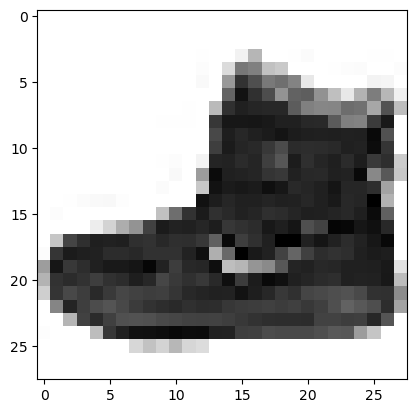

In [34]:
b = next(iter(dl)) # b is a dict
xb = b['image']  # xb is a minibatch
img = xb[0] # img is a single image
plt.imshow(img[0]);

In [35]:
type(b), xb.shape, img.shape

(dict, torch.Size([16, 1, 28, 28]), torch.Size([1, 28, 28]))

Let's define `show_image()`, which does `imshow()`, and a few extra things.
To ensure that: (1) it's in the correct axes order, (2) that's on the CPU,
(3) If it's not a NumPy array, convert it to a NumPy array, (4) set the size.
We'll be able to pass in an existing axis, set a title if we want to.
And remove the ugly axis because we're showing an image, we don't want any of that.

In [36]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute')):
        im = im.cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

In [37]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noframe=True, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show a PIL or PyTorch image on `ax`.



When we say help, the help shows what is implemented, and it also shows a lot more things.
How did that happen? 
We added `**kwargs` to the signature of the function.
`**kwargs` says you can pass it as many other arguments that aren't listed, and 
they'll all be put into a dictionary `kwargs`. 
When we call `imshow()` we pass that entire dictionary (** here means “as separate arguments”).
It knows what help to provide thanks to the `@delegates` decorator of fastcore.
It checks where we're going to be passing the `kwargs` to, (here to `imshow()`, 
and it automatically creates the documentation to show what kwargs can do.
A helpful way of extending existing functions like imshow with all of their functionality and all of their documentation. 
`delegates` is a very useful decorator in fastcore.

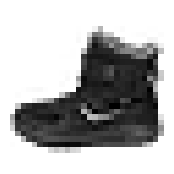

In [38]:
show_image(img, figsize=(2,2));

Matplotlib subplots are helpful.  
For example, if we want to plot two images next to each other.
Matplotlib.subplots creates multiple plots, where we pass the number of rows and columns, and it returns "axes", 
which are the individual plots.
Below we call `show_image()` on the first image, passing in `axs[0]`, and a second image on the second axis.

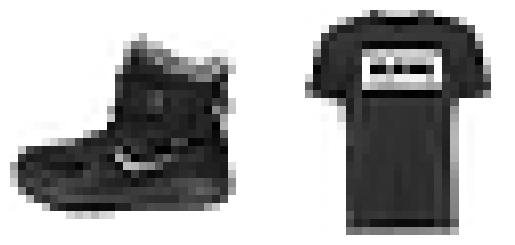

In [39]:
fig,axs = plt.subplots(1,2)
show_image(xb[0], axs[0])
show_image(xb[1], axs[1]);

Lets add additional functionality to `subplots`, using `@delegates`. 
We take `kwargs` and pass it through to  `subplots()`.
The goal is to automatically create an appropriate figure size,
and be able to add a title for the whole set of subplots.  

In [40]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches."
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = array([ax])
    return fig,ax

It will automatically create documentation for the library. 
For the stuff we added, it's telling what each of these parameters is, 
their type, defaults, and information about each one.  
That information is automatically coming from the comments inside the function definition. 
We call these documents.
This is all automatic stuff done by fastcore and  nbdev. 

In [41]:
from nbdev.showdoc import show_doc

In [42]:
show_doc(subplots)

---

[source](https://github.com/fastai/course22p2/blob/master/miniai/datasets.py#L52){target="_blank" style="float:right; font-size:smaller"}

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None, sharex=False, sharey=False, squeeze=True,
>                subplot_kw=None, gridspec_kw=None, **kwargs)

A figure and set of subplots to display images of `imsize` inches.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows in returned axes grid |
| ncols | int | 1 | Number of columns in returned axes grid |
| figsize | tuple | None | Width, height in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed in the returned figure |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |
| kwargs |  |  |  |

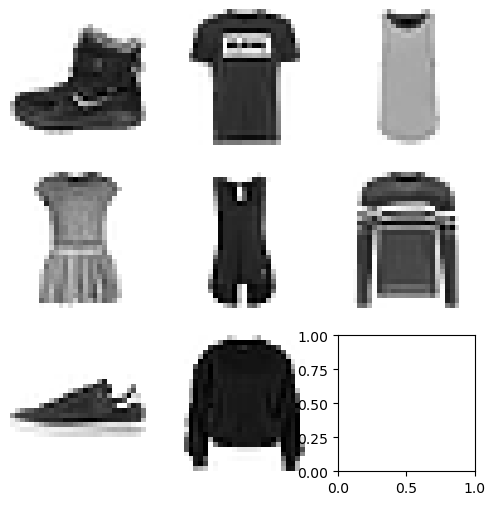

In [43]:
fig,axs = subplots(3,3, imsize=2)
imgs = xb[:8]
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

Lets fix the above 9th box ugliness.

In [44]:
#|export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.ceil(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

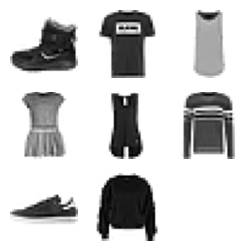

In [45]:
fig,axs = get_grid(8, nrows=3, imsize=1)
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [46]:
#|export
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int=1, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [47]:
yb = b['label']
lbls = yb[:8]

In [48]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

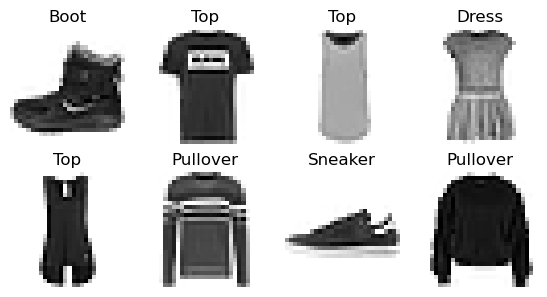

In [49]:
show_images(imgs, imsize=1.7, titles=titles)

## Export -

In [50]:
import nbdev; nbdev.nbdev_export()